In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import json
import cv2
import os

from tqdm import tqdm

In [2]:
def create_directory():
    os.makedirs("tusimple/images",exist_ok=True)
    os.makedirs("tusimple/mask",exist_ok=True)
    

In [3]:
create_directory()

In [4]:
masks_details={}
label_name=['label_data_0313.json','label_data_0531.json','label_data_0601.json']
for label in tqdm(label_name):
    with open(f"/kaggle/input/tusimple/TUSimple/train_set/{label}",'r') as f:
        while True:
            try:
                a=json.loads(f.readline())
                masks_details[a['raw_file']]=a
            except Exception as E:
                print(E)
                break

100%|██████████| 3/3 [00:00<00:00, 16.45it/s]

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)


In [5]:
# path_format -> clips_folderName_nestedFolderName_img_name
clips_path="/kaggle/input/tusimple/TUSimple/train_set/clips"
import shutil

for clipss in tqdm(os.listdir(clips_path)):
    # i=0;
    for clips in os.listdir(os.path.join(clips_path,clipss)):
        # if(i>500):
        #     break
        for clip in os.listdir(os.path.join(clips_path,clipss,clips)):
            # if(i>500):
            #     break
            img_path=os.path.join(clips_path,clipss,clips,clip)
            new_path=f"tusimple/images/clips_{clipss}_{clips}_{clip}"
            if not os.path.isfile(new_path) and masks_details.get(f'clips/{clipss}/{clips}/{clip}',0)!=0:
                shutil.copy(img_path,new_path)
                # i+=1

100%|██████████| 4/4 [00:57<00:00, 14.41s/it]


In [6]:
all_images=os.listdir("/kaggle/working/tusimple/images")
print(len(all_images)),len(masks_details)

3626


(None, 3626)

In [7]:
all_images=os.listdir("/kaggle/working/tusimple/images")
output_path="/kaggle/working/tusimple/mask"
for img in tqdm(all_images):
    mask_key=img.split('_')[0]+'/'+img.split('_')[1]+'/'+img.split('_')[2]+'/'+img.split('_')[3]
    temp=masks_details[mask_key]
    horz=temp['h_samples']
    lanes=temp['lanes']
    coord=[]
    mask=np.zeros((720,1280), dtype=np.uint8)
    for lane in lanes:
        points=[]
        for y,x in zip(horz,lane):
            if x!=-2:
                points.append([x,y])
        if len(points)>1:
            points = np.array(points, dtype=np.int32).reshape((-1,1,2))
            cv2.polylines(mask, [points], False, 1, thickness=10)
    if not os.path.isfile(output_path+'/'+img):
        cv2.imwrite(os.path.join(output_path,img),mask)
    # plt.imshow(mask,cmap='gray')
    # plt.show()

100%|██████████| 3626/3626 [00:06<00:00, 546.80it/s]


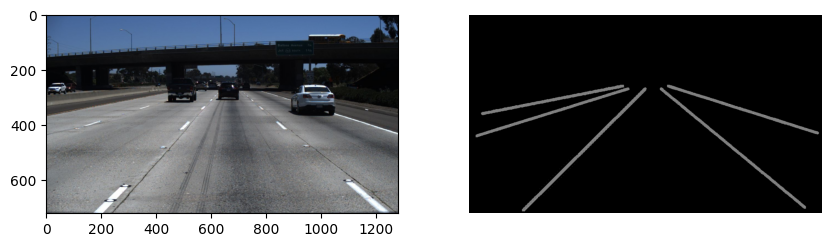

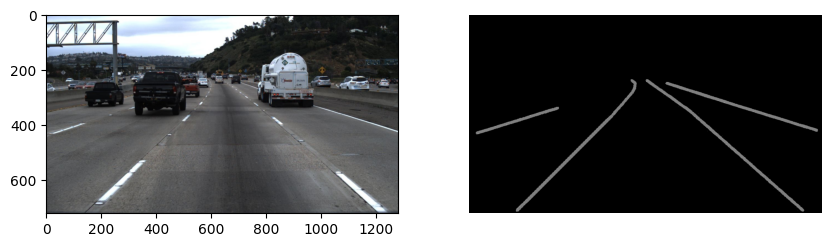

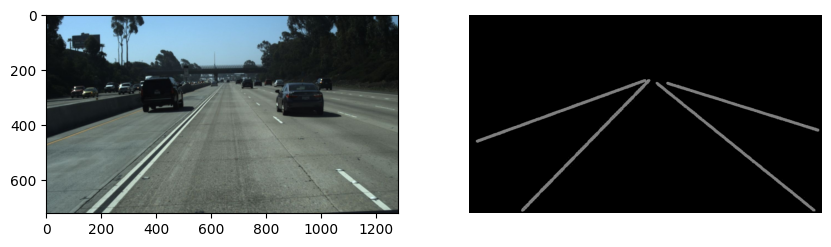

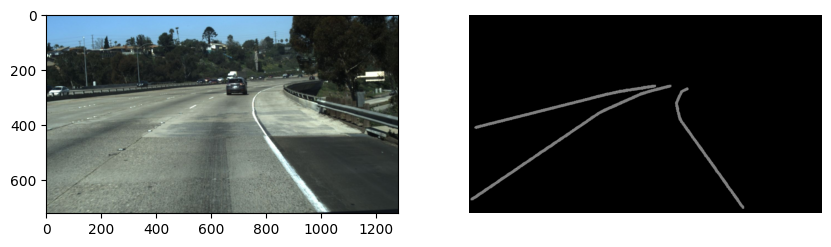

<Figure size 640x480 with 0 Axes>

In [8]:
base_dir=os.path.join("/kaggle","working","tusimple")

images=random.sample(sorted(os.listdir(os.path.join(base_dir,'images'))),4)

a=None
for i in range(len(images)):
  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  a=plt.imread(os.path.join(base_dir,'images',images[i]))
  plt.imshow(plt.imread(os.path.join(base_dir,'images',images[i])))
  plt.subplot(1,2,2)
  a=plt.imread(os.path.join(base_dir,'mask',images[i]))
  plt.imshow(plt.imread(os.path.join(base_dir,'mask',images[i])),cmap='gray')
  plt.axis('off')
  plt.show()
plt.tight_layout()

In [9]:
# validation data

all_images=os.listdir("/kaggle/working/tusimple/images")
val_images=random.sample(all_images,200)
all_images=[i for i in all_images if i not in val_images]
test_images=random.sample(all_images,300)
all_images=[i for i in all_images if i not in test_images]

os.makedirs("tusimple/train/images/images",exist_ok=True)
os.makedirs("tusimple/train/mask/mask",exist_ok=True)
os.makedirs("tusimple/val/images/images",exist_ok=True)
os.makedirs("tusimple/val/mask/mask",exist_ok=True)
os.makedirs("tusimple/test/images/images",exist_ok=True)
os.makedirs("tusimple/test/mask/mask",exist_ok=True)
    
for i in tqdm(val_images):
    img_path=f"/kaggle/working/tusimple/images/{i}"
    new_path=f"/kaggle/working/tusimple/val/images/images/{i}"
    shutil.move(img_path,new_path)
    img_path=f"/kaggle/working/tusimple/mask/{i}"
    new_path=f"/kaggle/working/tusimple/val/mask/mask/{i}"
    shutil.move(img_path,new_path)
    
for i in tqdm(test_images):
    img_path=f"/kaggle/working/tusimple/images/{i}"
    new_path=f"/kaggle/working/tusimple/test/images/images/{i}"
    shutil.move(img_path,new_path)
    img_path=f"/kaggle/working/tusimple/mask/{i}"
    new_path=f"/kaggle/working/tusimple/test/mask/mask/{i}"
    shutil.move(img_path,new_path)
    
for i in tqdm(all_images):
    img_path=f"/kaggle/working/tusimple/images/{i}"
    new_path=f"/kaggle/working/tusimple/train/images/images/{i}"
    shutil.move(img_path,new_path)
    img_path=f"/kaggle/working/tusimple/mask/{i}"
    new_path=f"/kaggle/working/tusimple/train/mask/mask/{i}"
    shutil.move(img_path,new_path)

100%|██████████| 3126/3126 [00:00<00:00, 19411.92it/s]


In [121]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import plotly.express as px

In [167]:
# 256,256 is giving me mean_iou: 0.3666 after 10 epochs
input_shape=(256,256,3)
mask_shape=(256,256,1)
BATCH_SIZE=32

In [168]:
def create_conv_block(n1,n2,k1,k2,l):
  l=layers.Conv2D(n1,k1,activation='relu',padding='same')(l)
  l=layers.Conv2D(n2,k2,activation='relu',padding='same')(l)
  return l

In [169]:
input=layers.Input(shape=input_shape)

c1=create_conv_block(16,16,3,3,input)

c2=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(c1)
c2=create_conv_block(32,32,3,3,c2)

c3=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(c2)
c3=create_conv_block(64,64,3,3,c3)

c4=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(c3)
c4=create_conv_block(128,128,3,3,c4)

c5=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(c4)
c5=create_conv_block(256,256,3,3,c5)


bottom=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(c5)
conv_1x1=layers.Conv2D(256,1,activation='relu',padding='same')(bottom)
conv_1x1_2=layers.Conv2D(256,1,activation='relu',padding='same')(conv_1x1)

c5_up=layers.Conv2DTranspose(256,2,strides=(2,2),padding='same')(conv_1x1_2)
c5_up=layers.concatenate([c5,c5_up])
c5_up=create_conv_block(256,256,3,3,c5_up)

c4_up=layers.Conv2DTranspose(128,2,strides=(2,2),padding='same')(c5_up)
c4_up=layers.concatenate([c4,c4_up])
c4_up=create_conv_block(128,128,3,3,c4_up)

c3_up=layers.Conv2DTranspose(64,2,strides=(2,2),padding='same')(c4_up)
c3_up=layers.concatenate([c3,c3_up])
c3_up=create_conv_block(64,64,3,3,c3_up)

c2_up=layers.Conv2DTranspose(32,2,strides=(2,2),padding='same')(c3_up)
c2_up=layers.concatenate([c2,c2_up])
c2_up=create_conv_block(32,32,3,3,c2_up)

c1_up=layers.Conv2DTranspose(16,2,strides=(2,2),padding='same')(c2_up)
c1_up=layers.concatenate([c1,c1_up])
c1_up=create_conv_block(16,16,3,3,c1_up)

output=layers.Conv2D(1,1,activation='sigmoid')(c1_up)


model=keras.Model(inputs=input,outputs=output)

In [170]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_61[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 128, 128,  │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_63[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 64, 64,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_14… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_65[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 32, 32,    │          0 │ conv2d_66[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_67[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 16, 16,    │          0 │ conv2d_68[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_16… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_69[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 8, 8, 256) │          0 │ conv2d_70[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 8, 8, 256) │     65,792 │ max_pooling2d_17

 Total params: 4,105,073 (15.66 MB)

 Trainable params: 4,105,073 (15.66 MB)

 Non-trainable params: 0 (0.00 B)

In [171]:
from tensorflow.keras import callbacks
images=random.sample(sorted(os.listdir(os.path.join(base_dir,'train','images','images'))),2)
def show_random_images():
    global images
    for i in range(len(images)):
      plt.figure(figsize=(10,10))
      plt.subplot(1,3,1)
      a=plt.imread(os.path.join(base_dir,'train','images','images',images[i]))
      plt.imshow(plt.imread(os.path.join(base_dir,'train','images','images',images[i])))
      plt.subplot(1,3,2)
        
      plt.imshow(plt.imread(os.path.join(base_dir,'train','mask','mask',images[i])),cmap='gray')
      plt.subplot(1,3,3)
      a=cv2.resize(a,(input_shape[0],input_shape[1]))
      a=np.expand_dims(a,axis=0)
      a=model.predict(a)[0]
      plt.imshow(a,cmap='gray')
      plt.axis('off')
      plt.tight_layout()
      plt.show()

class random_images(callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        show_random_images()

In [172]:
# show_random_images()

In [173]:
import tensorflow.keras.backend as K
def mean_iou(y_true, y_pred,smooth=1):
    # plt.imshow(y_pred)
    # plt.show()
    # plt.imshow(y_true)
    # plt.show()
    y_true=K.flatten(y_true)
    y_pred=K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [174]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

In [175]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy',mean_iou,dice_coefficient])

In [176]:
# generators
train_data_X=keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
val_data_X=keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
test_data_X=keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
train_data_y=keras.preprocessing.image.ImageDataGenerator(
)
val_data_y=keras.preprocessing.image.ImageDataGenerator(
)
test_data_y=keras.preprocessing.image.ImageDataGenerator(
)

base_dir=os.path.join("/kaggle","working","tusimple")
train_data_X=train_data_X.flow_from_directory(class_mode=None,directory=os.path.join(base_dir,'train','images'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,seed=42)
val_data_X=val_data_X.flow_from_directory(class_mode=None,directory=os.path.join(base_dir,'val','images'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,seed=42)
test_data_X=test_data_X.flow_from_directory(class_mode=None,directory=os.path.join(base_dir,'test','images'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,seed=42)

train_data_y=train_data_y.flow_from_directory(class_mode=None,directory=os.path.join(base_dir,'train','mask'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,color_mode='grayscale',seed=42)
val_data_y=val_data_y.flow_from_directory(class_mode=None,directory=os.path.join(base_dir,'val','mask'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,color_mode='grayscale',seed=42)
test_data_y=test_data_y.flow_from_directory(class_mode=None,directory=os.path.join(base_dir,'test','mask'),target_size=(input_shape[0],input_shape[1]),batch_size=BATCH_SIZE,color_mode='grayscale',seed=42)


Found 3126 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 300 images belonging to 1 classes.
Found 3126 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 300 images belonging to 1 classes.


In [177]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(patience=5,monitor='val_loss',verbose=1)
red_lr=ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1)
check_pt=ModelCheckpoint('model.h5',verbose=1,monitor='val_loss',save_best_only=True)

In [178]:
def combined_data_gen(gen_x,gen_y):
  for x,y in zip(gen_x,gen_y):
    yield x,y

In [179]:
train_data_gen=combined_data_gen(train_data_X,train_data_y)
val_data_gen=combined_data_gen(val_data_X,val_data_y)
test_data_gen=combined_data_gen(test_data_X,test_data_y)

Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9719 - dice_coefficient: 0.0341 - loss: 0.2648 - mean_iou: 0.0174
Epoch 1: val_loss improved from inf to 0.10886, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


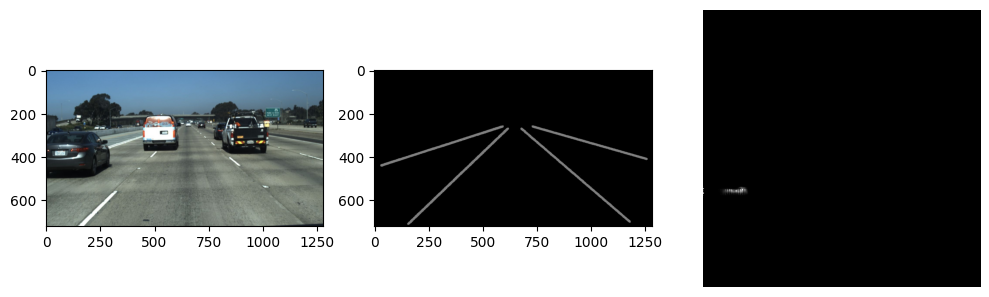

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


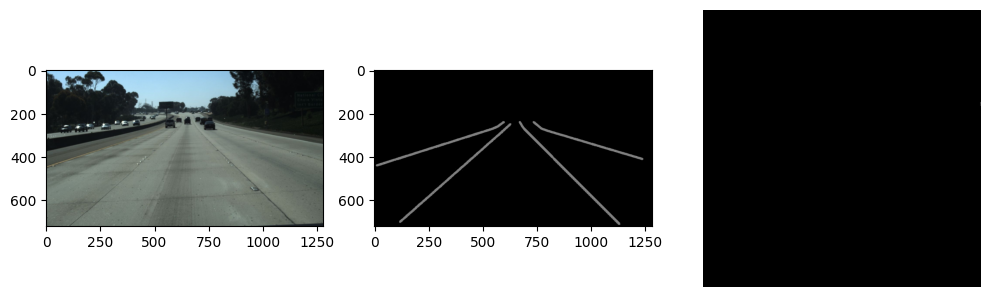

97/97 ━━━━━━━━━━━━━━━━━━━━ 64s 366ms/step - accuracy: 0.9719 - dice_coefficient: 0.0342 - loss: 0.2638 - mean_iou: 0.0175 - val_accuracy: 0.9720 - val_dice_coefficient: 0.0796 - val_loss: 0.1089 - val_mean_iou: 0.0415 - learning_rate: 0.0010
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9725 - dice_coefficient: 0.0965 - loss: 0.0979 - mean_iou: 0.0509
Epoch 2: val_loss improved from 0.10886 to 0.07881, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


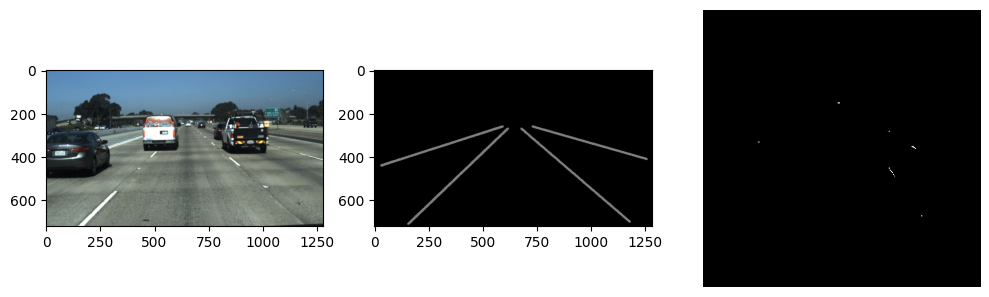

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


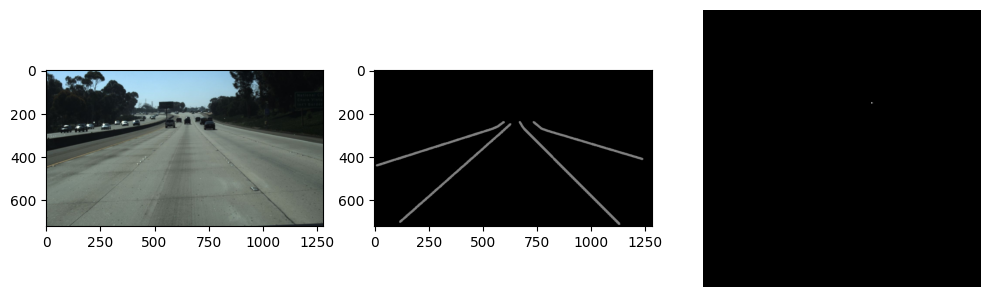

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 273ms/step - accuracy: 0.9725 - dice_coefficient: 0.0968 - loss: 0.0978 - mean_iou: 0.0511 - val_accuracy: 0.9721 - val_dice_coefficient: 0.2006 - val_loss: 0.0788 - val_mean_iou: 0.1115 - learning_rate: 0.0010
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9735 - dice_coefficient: 0.2395 - loss: 0.0741 - mean_iou: 0.1365
Epoch 3: val_loss improved from 0.07881 to 0.06452, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


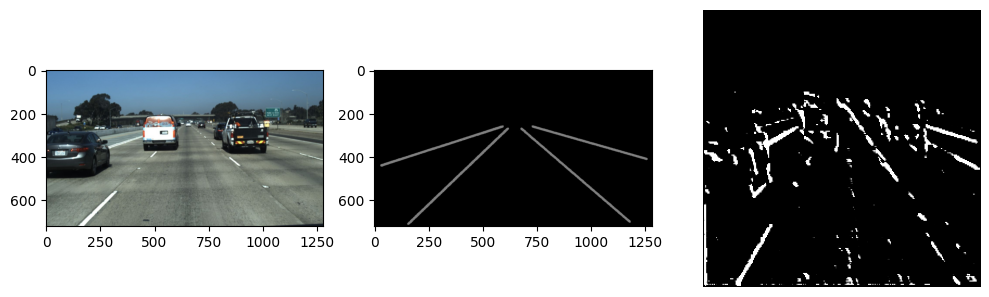

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


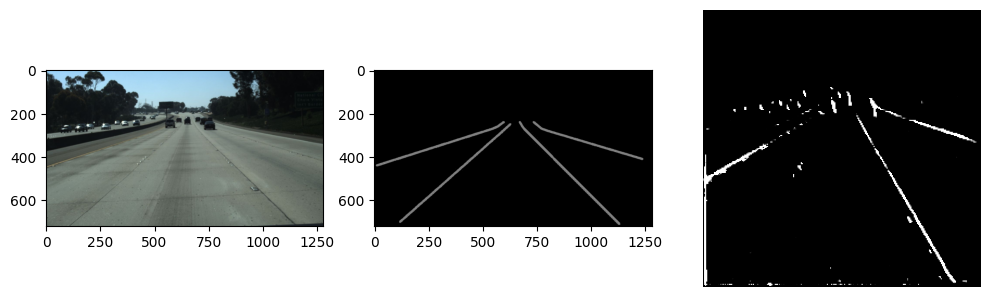

97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - accuracy: 0.9735 - dice_coefficient: 0.2399 - loss: 0.0741 - mean_iou: 0.1368 - val_accuracy: 0.9742 - val_dice_coefficient: 0.3474 - val_loss: 0.0645 - val_mean_iou: 0.2102 - learning_rate: 0.0010
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9771 - dice_coefficient: 0.3862 - loss: 0.0572 - mean_iou: 0.2396
Epoch 4: val_loss improved from 0.06452 to 0.05785, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


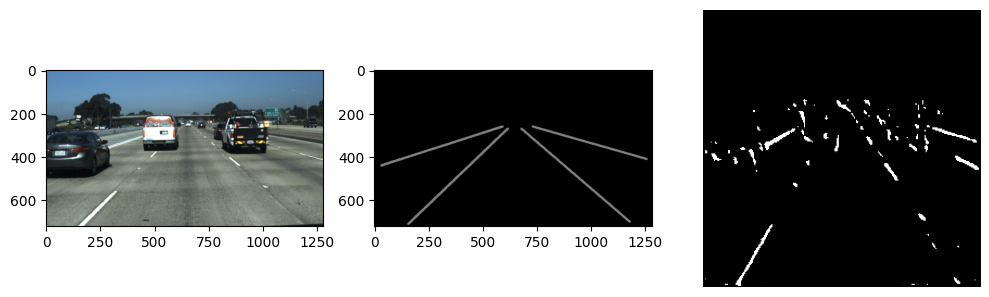

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


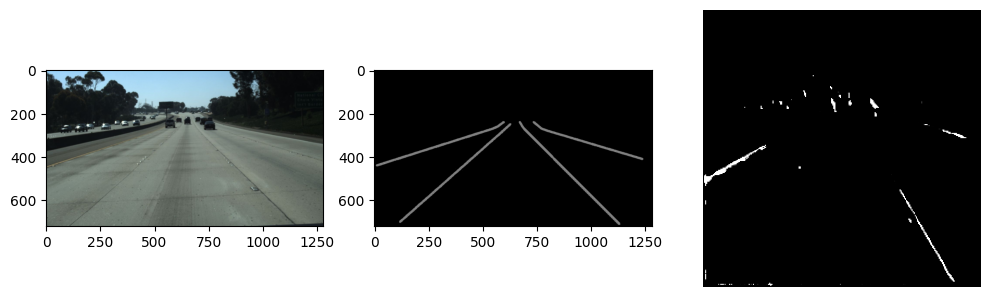

97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - accuracy: 0.9772 - dice_coefficient: 0.3864 - loss: 0.0572 - mean_iou: 0.2397 - val_accuracy: 0.9761 - val_dice_coefficient: 0.4170 - val_loss: 0.0579 - val_mean_iou: 0.2636 - learning_rate: 0.0010
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9790 - dice_coefficient: 0.4472 - loss: 0.0508 - mean_iou: 0.2882
Epoch 5: val_loss improved from 0.05785 to 0.05138, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


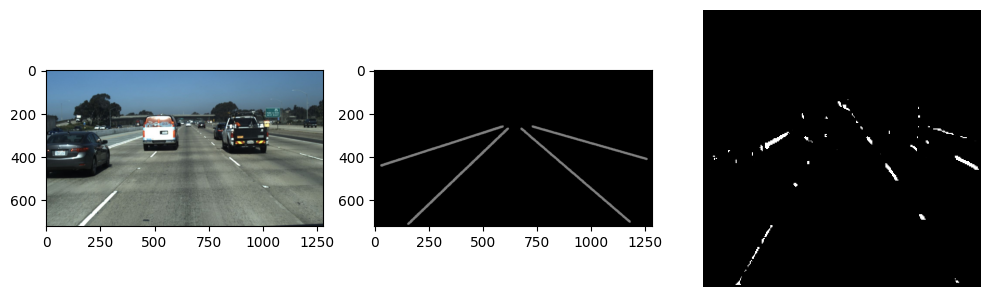

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


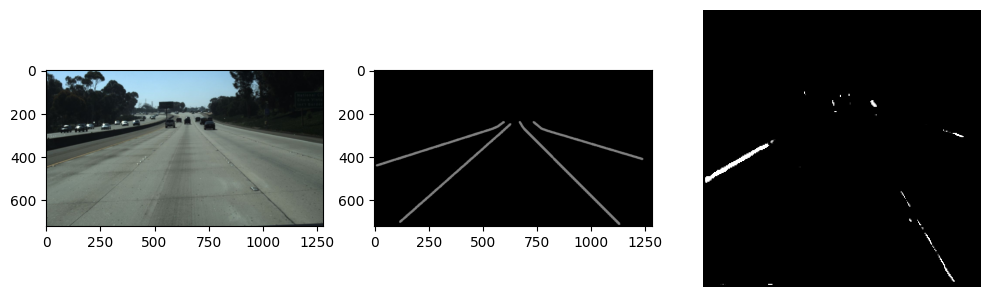

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - accuracy: 0.9790 - dice_coefficient: 0.4472 - loss: 0.0508 - mean_iou: 0.2882 - val_accuracy: 0.9785 - val_dice_coefficient: 0.4770 - val_loss: 0.0514 - val_mean_iou: 0.3134 - learning_rate: 0.0010
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9805 - dice_coefficient: 0.4897 - loss: 0.0460 - mean_iou: 0.3244
Epoch 6: val_loss improved from 0.05138 to 0.04883, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


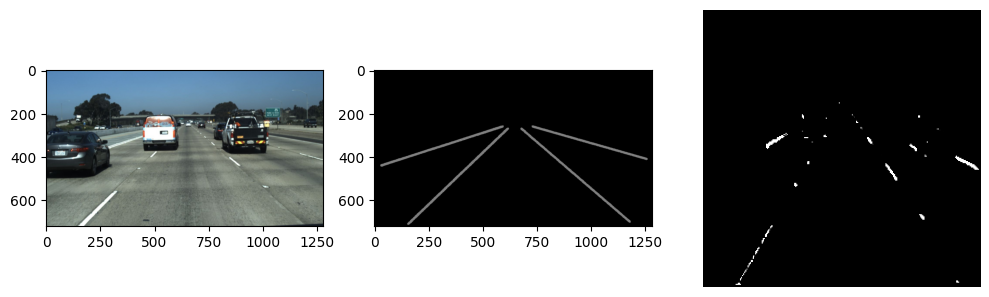

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


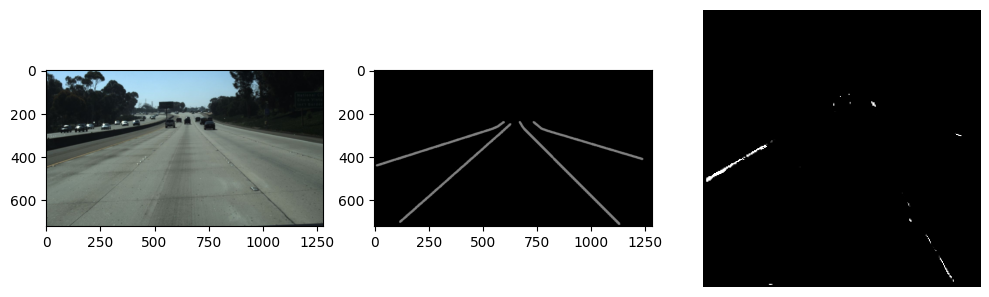

97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 259ms/step - accuracy: 0.9805 - dice_coefficient: 0.4898 - loss: 0.0460 - mean_iou: 0.3245 - val_accuracy: 0.9793 - val_dice_coefficient: 0.4964 - val_loss: 0.0488 - val_mean_iou: 0.3303 - learning_rate: 0.0010
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9812 - dice_coefficient: 0.5132 - loss: 0.0437 - mean_iou: 0.3454
Epoch 7: val_loss improved from 0.04883 to 0.04796, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


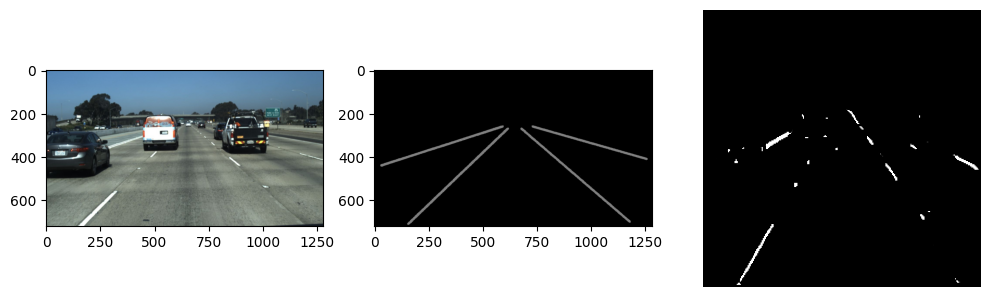

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


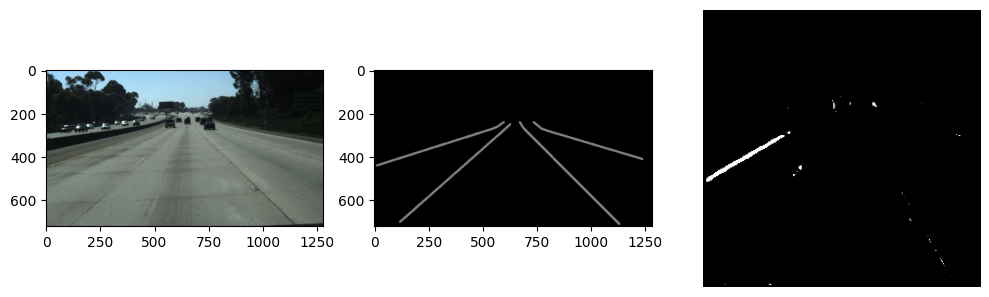

97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - accuracy: 0.9812 - dice_coefficient: 0.5133 - loss: 0.0437 - mean_iou: 0.3454 - val_accuracy: 0.9796 - val_dice_coefficient: 0.5079 - val_loss: 0.0480 - val_mean_iou: 0.3404 - learning_rate: 0.0010
Epoch 8/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9817 - dice_coefficient: 0.5268 - loss: 0.0424 - mean_iou: 0.3577
Epoch 8: val_loss improved from 0.04796 to 0.04465, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


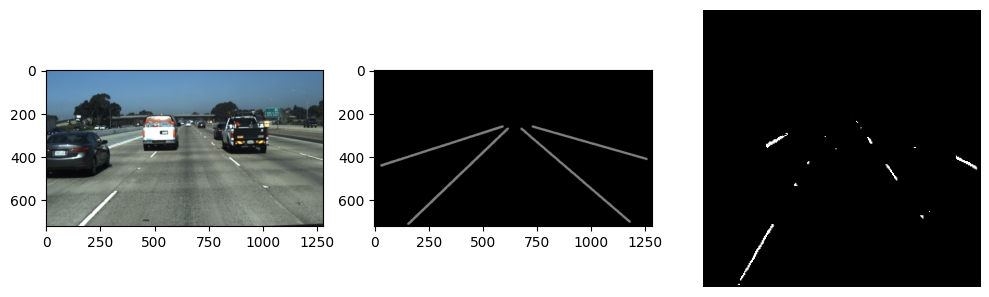

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


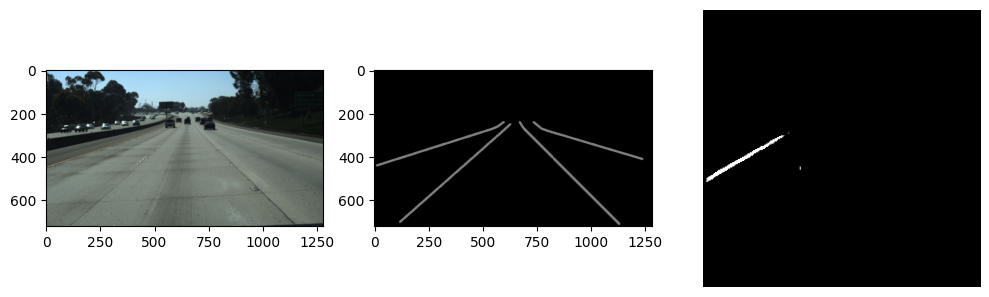

97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.9817 - dice_coefficient: 0.5268 - loss: 0.0424 - mean_iou: 0.3577 - val_accuracy: 0.9809 - val_dice_coefficient: 0.5134 - val_loss: 0.0446 - val_mean_iou: 0.3456 - learning_rate: 0.0010
Epoch 9/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9819 - dice_coefficient: 0.5346 - loss: 0.0415 - mean_iou: 0.3650
Epoch 9: val_loss did not improve from 0.04465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


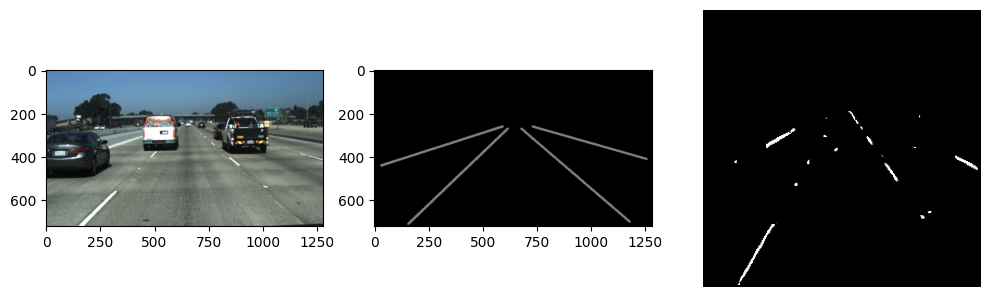

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


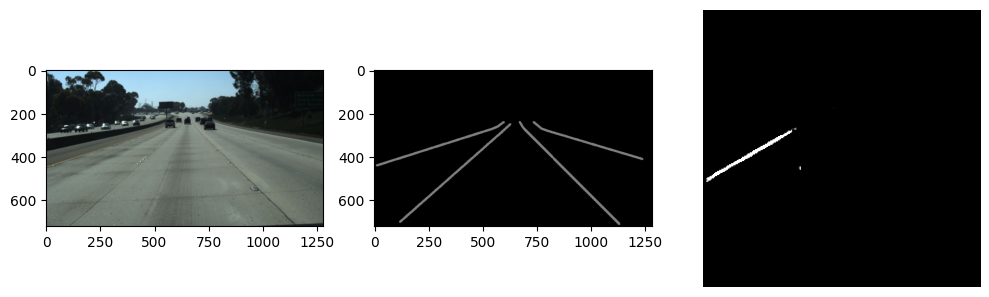

97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.9819 - dice_coefficient: 0.5346 - loss: 0.0415 - mean_iou: 0.3650 - val_accuracy: 0.9807 - val_dice_coefficient: 0.5300 - val_loss: 0.0446 - val_mean_iou: 0.3606 - learning_rate: 0.0010
Epoch 10/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9821 - dice_coefficient: 0.5441 - loss: 0.0408 - mean_iou: 0.3739
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 10: val_loss did not improve from 0.04465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


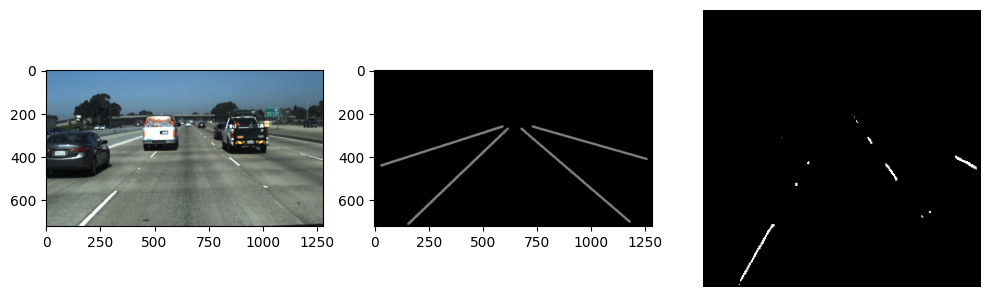

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


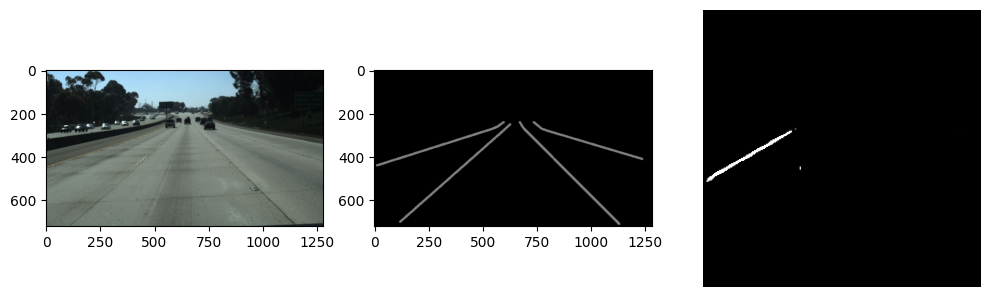

97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - accuracy: 0.9821 - dice_coefficient: 0.5442 - loss: 0.0408 - mean_iou: 0.3739 - val_accuracy: 0.9806 - val_dice_coefficient: 0.5390 - val_loss: 0.0447 - val_mean_iou: 0.3690 - learning_rate: 0.0010
Epoch 11/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9834 - dice_coefficient: 0.5742 - loss: 0.0377 - mean_iou: 0.4029
Epoch 11: val_loss improved from 0.04465 to 0.04177, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


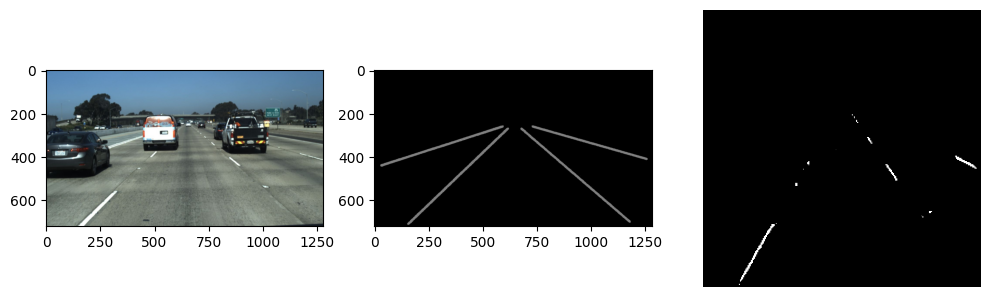

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


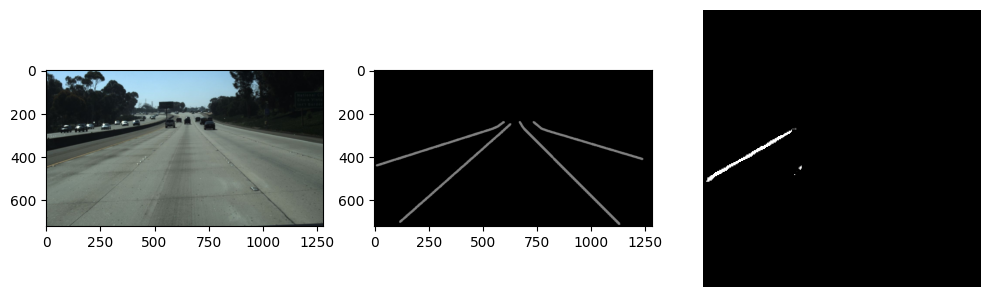

97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 265ms/step - accuracy: 0.9834 - dice_coefficient: 0.5743 - loss: 0.0377 - mean_iou: 0.4029 - val_accuracy: 0.9817 - val_dice_coefficient: 0.5632 - val_loss: 0.0418 - val_mean_iou: 0.3921 - learning_rate: 1.0000e-04
Epoch 12/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9838 - dice_coefficient: 0.5856 - loss: 0.0366 - mean_iou: 0.4141
Epoch 12: val_loss did not improve from 0.04177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


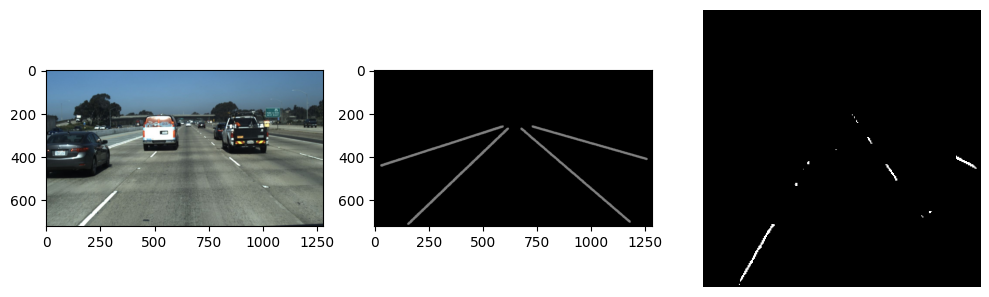

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


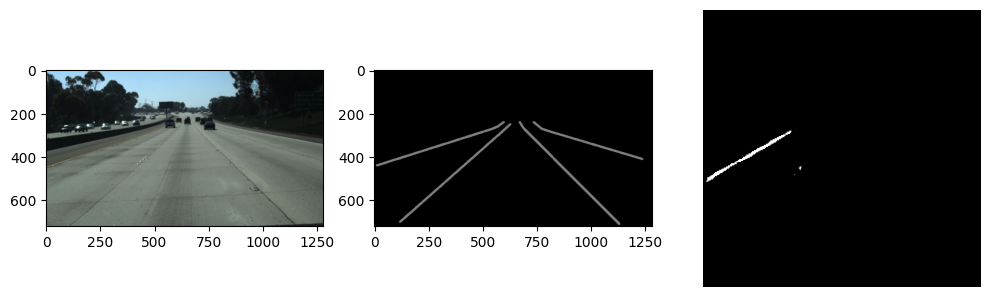

97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - accuracy: 0.9838 - dice_coefficient: 0.5857 - loss: 0.0366 - mean_iou: 0.4142 - val_accuracy: 0.9813 - val_dice_coefficient: 0.5583 - val_loss: 0.0426 - val_mean_iou: 0.3873 - learning_rate: 1.0000e-04
Epoch 13/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9840 - dice_coefficient: 0.5914 - loss: 0.0359 - mean_iou: 0.4199
Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 13: val_loss did not improve from 0.04177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


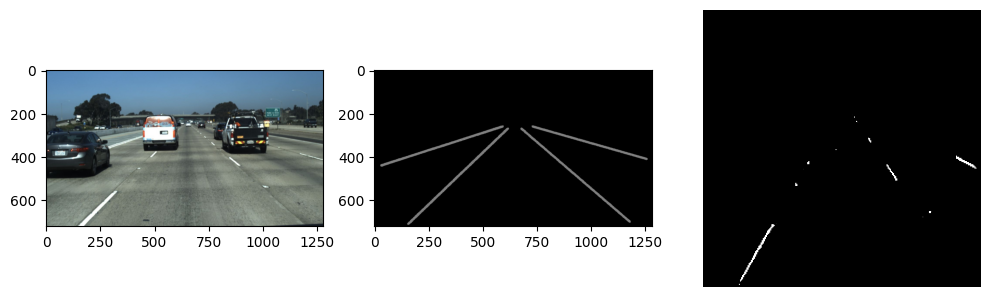

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


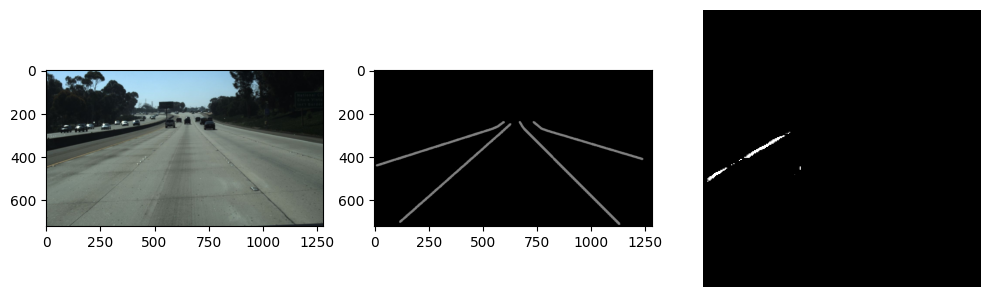

97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 259ms/step - accuracy: 0.9840 - dice_coefficient: 0.5914 - loss: 0.0359 - mean_iou: 0.4199 - val_accuracy: 0.9815 - val_dice_coefficient: 0.5521 - val_loss: 0.0429 - val_mean_iou: 0.3814 - learning_rate: 1.0000e-04
Epoch 14/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9840 - dice_coefficient: 0.5920 - loss: 0.0359 - mean_iou: 0.4205
Epoch 14: val_loss improved from 0.04177 to 0.04085, saving model to model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


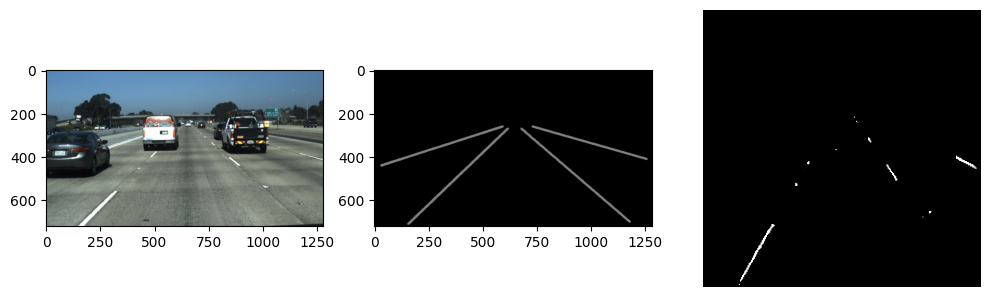

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


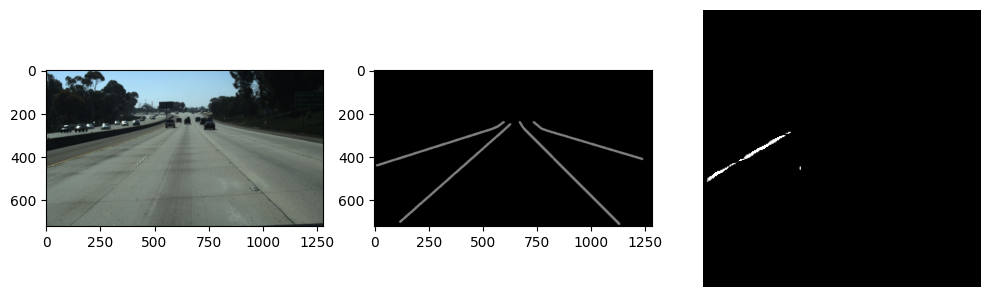

97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - accuracy: 0.9840 - dice_coefficient: 0.5920 - loss: 0.0359 - mean_iou: 0.4205 - val_accuracy: 0.9821 - val_dice_coefficient: 0.5672 - val_loss: 0.0409 - val_mean_iou: 0.3959 - learning_rate: 1.0000e-05
Epoch 15/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9845 - dice_coefficient: 0.5983 - loss: 0.0350 - mean_iou: 0.4270
Epoch 15: val_loss did not improve from 0.04085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


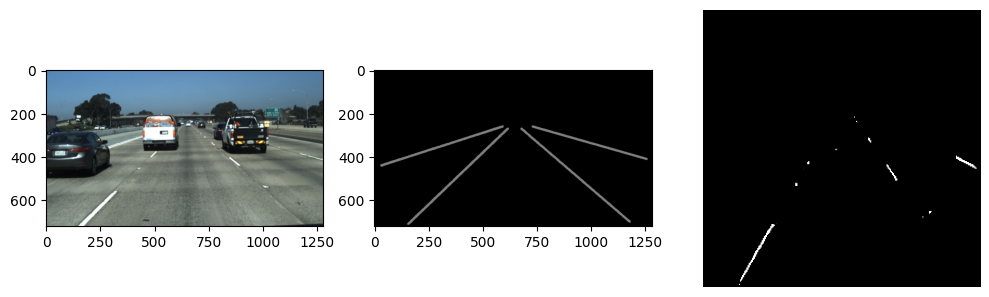

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


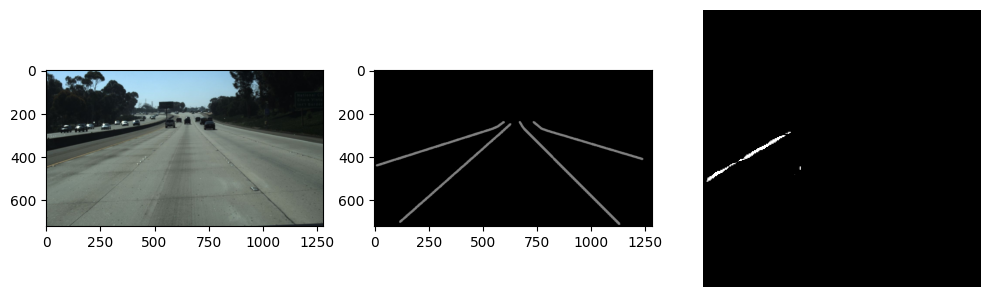

97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - accuracy: 0.9845 - dice_coefficient: 0.5983 - loss: 0.0351 - mean_iou: 0.4269 - val_accuracy: 0.9810 - val_dice_coefficient: 0.5566 - val_loss: 0.0432 - val_mean_iou: 0.3857 - learning_rate: 1.0000e-05
Epoch 16/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9843 - dice_coefficient: 0.5989 - loss: 0.0353 - mean_iou: 0.4276
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 16: val_loss did not improve from 0.04085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


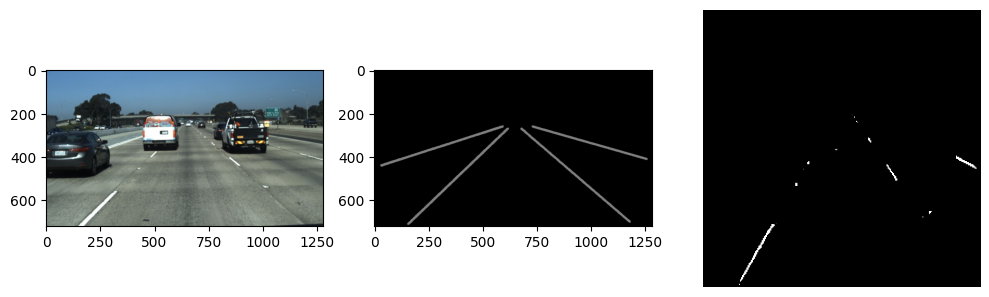

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


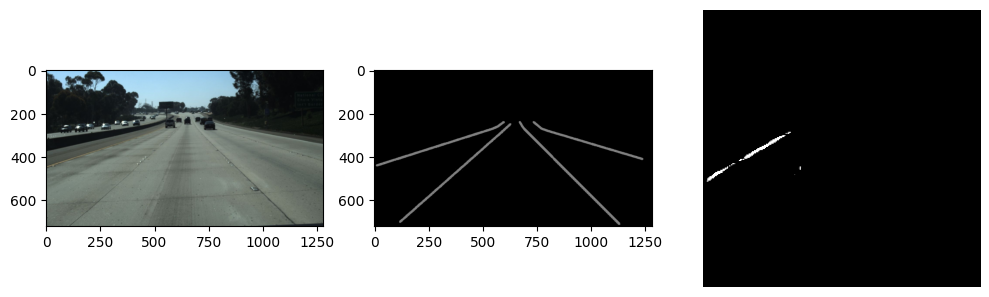

97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 272ms/step - accuracy: 0.9843 - dice_coefficient: 0.5989 - loss: 0.0353 - mean_iou: 0.4276 - val_accuracy: 0.9815 - val_dice_coefficient: 0.5590 - val_loss: 0.0431 - val_mean_iou: 0.3880 - learning_rate: 1.0000e-05
Epoch 17/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9841 - dice_coefficient: 0.5958 - loss: 0.0356 - mean_iou: 0.4244
Epoch 17: val_loss did not improve from 0.04085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


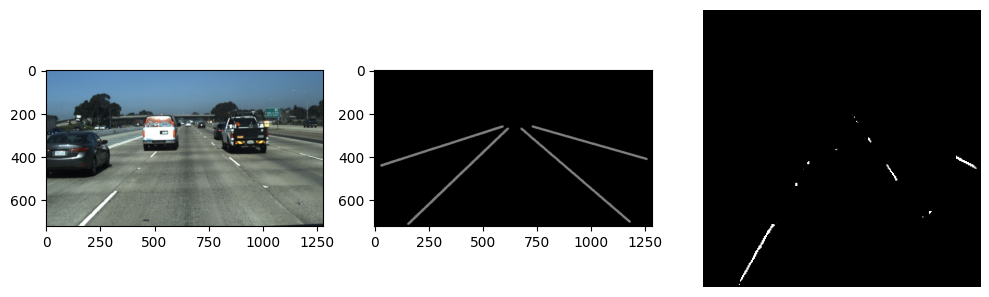

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


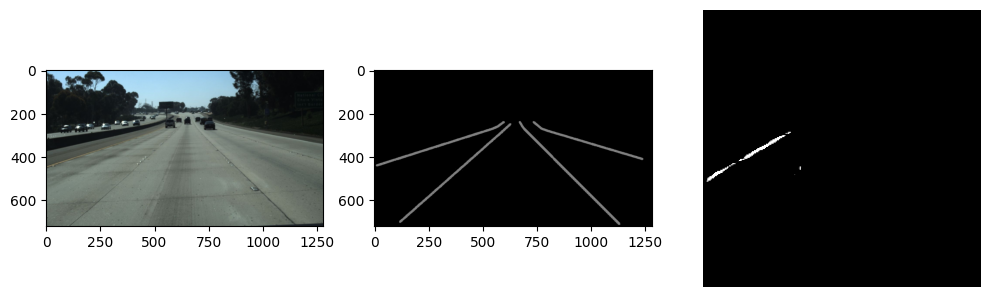

97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - accuracy: 0.9841 - dice_coefficient: 0.5958 - loss: 0.0356 - mean_iou: 0.4244 - val_accuracy: 0.9812 - val_dice_coefficient: 0.5593 - val_loss: 0.0431 - val_mean_iou: 0.3883 - learning_rate: 1.0000e-06
Epoch 18/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9844 - dice_coefficient: 0.5969 - loss: 0.0352 - mean_iou: 0.4256
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 18: val_loss did not improve from 0.04085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


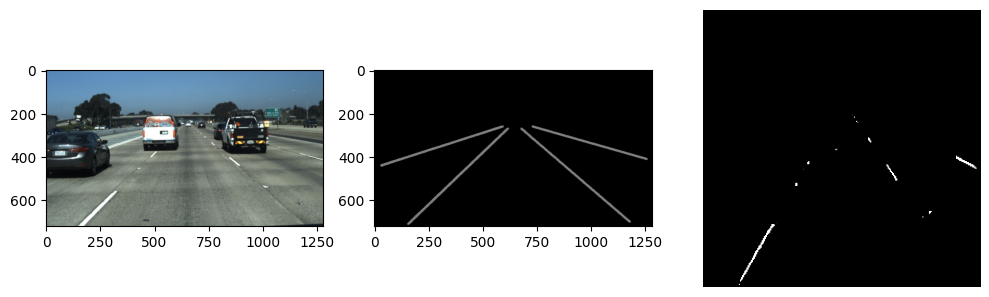

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


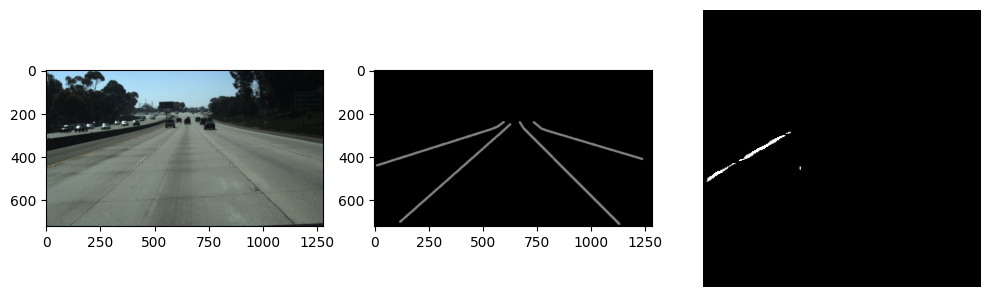

97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - accuracy: 0.9844 - dice_coefficient: 0.5969 - loss: 0.0352 - mean_iou: 0.4256 - val_accuracy: 0.9816 - val_dice_coefficient: 0.5637 - val_loss: 0.0422 - val_mean_iou: 0.3925 - learning_rate: 1.0000e-06
Epoch 19/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9844 - dice_coefficient: 0.5981 - loss: 0.0353 - mean_iou: 0.4267
Epoch 19: val_loss did not improve from 0.04085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


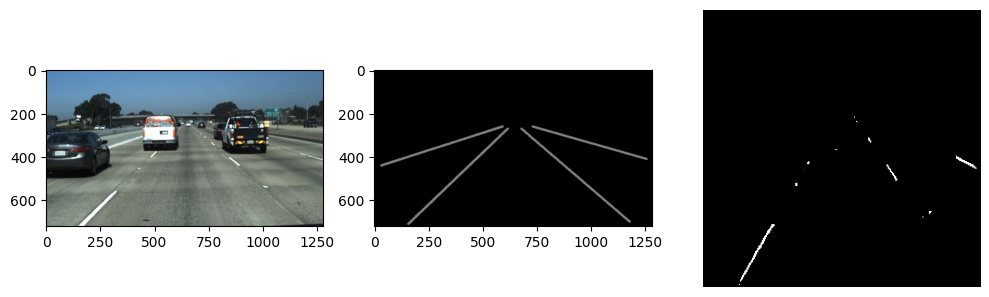

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


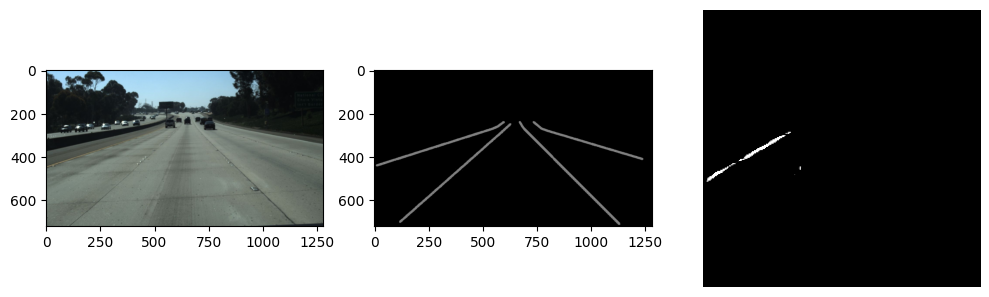

97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 265ms/step - accuracy: 0.9844 - dice_coefficient: 0.5981 - loss: 0.0353 - mean_iou: 0.4267 - val_accuracy: 0.9819 - val_dice_coefficient: 0.5646 - val_loss: 0.0411 - val_mean_iou: 0.3934 - learning_rate: 1.0000e-07
Epoch 19: early stopping


In [180]:
steps_per_epoch = len(os.listdir("/kaggle/working/tusimple/train/images/images")) // BATCH_SIZE
validation_steps = len(os.listdir("/kaggle/working/tusimple/val/images/images")) // BATCH_SIZE
rnd=random_images()
history=model.fit(train_data_gen,epochs=40,validation_data=(val_data_gen),batch_size=BATCH_SIZE,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,callbacks=[early_stop,red_lr,check_pt,rnd])

# Evaluation and prediction

In [185]:
# load saved model
from tensorflow.keras.models import load_model
steps_per_epoch = len(os.listdir("/kaggle/working/tusimple/test/images/images")) // BATCH_SIZE

model = load_model("/kaggle/working/model.h5",custom_objects={'mean_iou': mean_iou,'dice_coefficient':dice_coefficient})

In [194]:
# metrics testing on val_data
model.evaluate(test_data_gen,batch_size=BATCH_SIZE,steps=steps_per_epoch)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.9829 - dice_coefficient: 0.5756 - loss: 0.0403 - mean_iou: 0.4042


[0.03952234983444214, 0.9829164147377014, 0.4059080183506012, 0.5772745013237]

In [192]:
def show_predictions():
    images=random.sample(sorted(os.listdir("/kaggle/working/tusimple/test/images/images")),4)
    
    for i in range(len(images)):
      plt.figure(figsize=(10,10))
      plt.subplot(1,2,1)
      a=plt.imread(os.path.join("/kaggle/working/tusimple/test/images/images",images[i]))
      plt.imshow(plt.imread(os.path.join("/kaggle/working/tusimple/test/images/images",images[i])))
      plt.subplot(1,2,2)

      a=cv2.resize(a,(input_shape[0],input_shape[1]))
      a=np.expand_dims(a,axis=0)
      print(a.shape)
      a=model.predict(a)[0]
      plt.imshow(a,cmap='gray')
      plt.axis('off')
      plt.show()
    plt.tight_layout()

(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


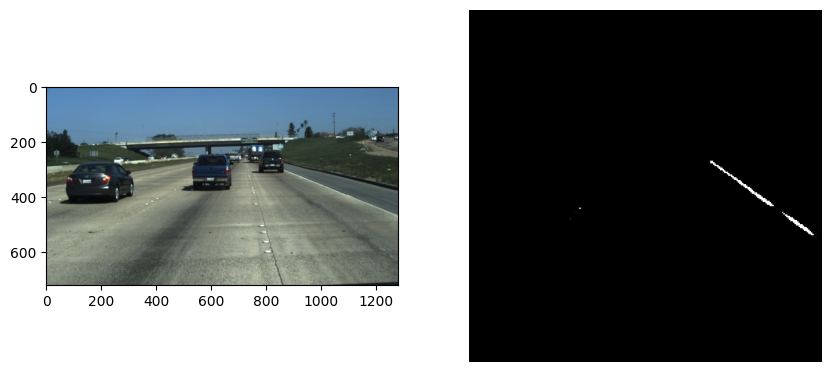

(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


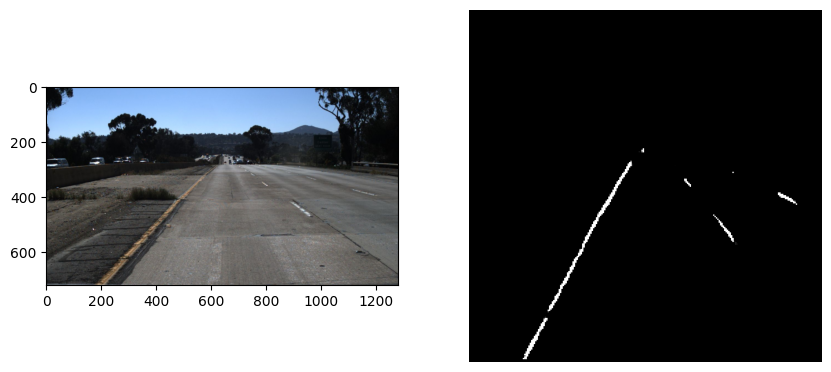

(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


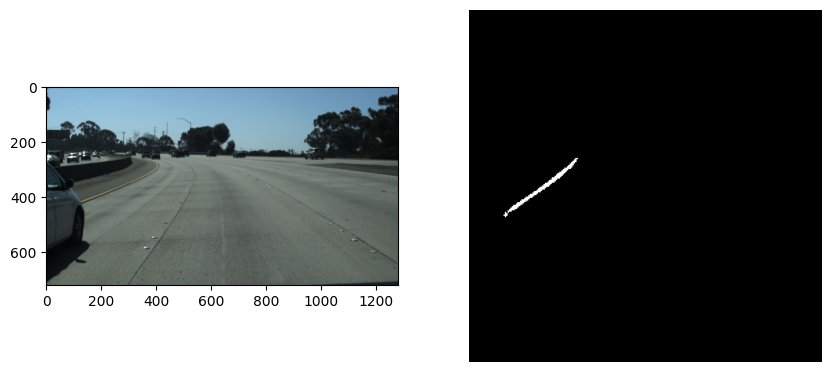

(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


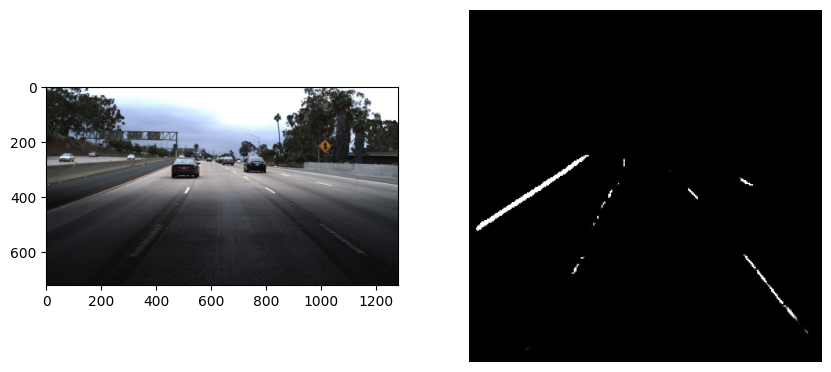

<Figure size 640x480 with 0 Axes>

In [193]:
show_predictions()